# Installing Net2Brain and Relevant Dependencies

In [ ]:
# !pip install -U git+https://github.com/cvai-roig-lab/Net2Brain



---



---


## Restart Runtime



---



---


# Load Dataset

In [ ]:
from net2brain.utils.download_datasets import load_workshop
data_dir = load_workshop("cutting_gardens23")

## Unraveling Temporal Processing Hierarchies With ANN

Previous research demonstrated that 2D, 3D, and Semantic network can act as proxies for various cognitive processes [Dwivedi 2021].

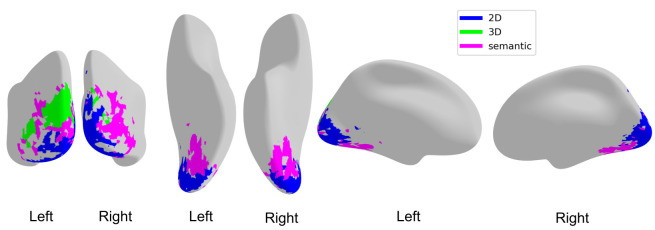

This same process can be used to unravel how cognitive representations unravel through time instead of space.


## Roadmap


1. **Create an RDM from the EEG**: Leave one out pairwise classification
2. **Loading Models**: Loading 2d, 3D, and Semantic models from `Net2Brain`
3. **Feature Generation**: Extracting model feautures using the `BonnerPnas2017`-Dataset
4. **RDM Creating**: Turning the features from both models into one RDM per network layer
5. **Evaluation through RSA**: Comparing model to PPA-representations using RSA


[Dwivedi 2021] Dwivedi K, Bonner MF, Cichy RM, Roig G. Unveiling functions of the visual cortex using task-specific deep neural networks. PLoS Comput Biol. 2021

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
subj_data = np.load(data_dir+'/data_sml.npy', allow_pickle=True)[()]

In [ ]:
subj_data['dat'].shape

In [ ]:
subj_data['lbl'].shape

### 1. Claculating EEG RDMs
For each pair of images i,j find associated eeg trials X<sub>i</sub> and X<sub>j</sub> and using leave one out cross validation train a classifier, average accuracy is used for a distance measure. This is done at every timepoint. Pseudo code:

```
for t in timepoints
    for i,j in image pairs
        accuracy_ij = 0
        for k in number of instances
            trn_I = all EEG instances for image i except k
            trn_J = all EEG instances for image j except k
            tst_I = EEG instance k for image i
            tst_J = EEG instance k for image j
            LDA.fit([trn_I,trn_J])
            accuracy_ij += LDA.predict([tst_I,tst_j])
        RDM[i,j,tt] = accuracy_ij
```

In [ ]:
from net2brain.preprocess.rdm import eeg_rdm
rdm = eeg_rdm(subj_data['dat'],subj_data['lbl'])

In [ ]:
plt.matshow(rdm[:,:,5])

### 2. Loading Models
To extract activations from a pretrained model of one of the netsets available with Net2Brain, you must first initialize the `FeatureExtractor` class and specify the name of the model as well as the netset it belongs to.

__Note__: If you want to implement your _own_ pre-trained ANN, use the model as an argument of `Feature Extractor` like:
`FeatureExtractor(model=my_model, device='cuda')`

In [ ]:
from net2brain.feature_extraction import print_netset_models
print_netset_models('Taskonomy')

In [ ]:
model_name = 'autoencoding'

In [ ]:
from net2brain.feature_extraction import FeatureExtractor

fx_model = FeatureExtractor(model=model_name,
                            netset='Taskonomy',
                            device='cuda')

### 3. Feature Generation

In [ ]:
# Create features for the chosen model
ft_path = f'feats_{model_name}'
fx_model.extract(data_path=data_dir+'./BonnerPnas2017',
                 save_path=ft_path,
                 layers_to_extract=['layer4'])

### RDM Creating:

In [ ]:
from net2brain.rdm_creation import RDMCreator

# Create RDMs for the model
creator_class = RDMCreator()
creator_class.create_rdms(feature_path=ft_path, save_path='model_rdm', save_format="npz")

In [ ]:
plt.matshow(np.load('./model_rdm/layer4.npz')['arr_0'])

## Evaluation
Instead of RSA we will use unique variance partioning

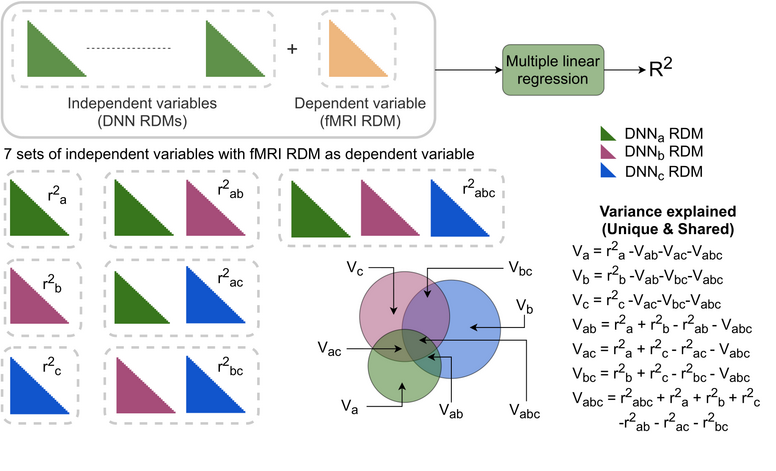

# Loading all Data

In [ ]:
import os

In [ ]:
myPath = data_dir
myPath = os.path.abspath(myPath)

In [ ]:
paths_2D = ['RDM_taskonomy_nav/autoencoder_encoder_block4.mat',
            'RDM_taskonomy_nav/colorization_encoder_block4.mat',
            'RDM_taskonomy_nav/denoise_encoder_block4.mat',
            'RDM_taskonomy_nav/edge2d_encoder_block4.mat',
            'RDM_taskonomy_nav/inpainting_whole_encoder_block4.mat',
            'RDM_taskonomy_nav/keypoint2d_encoder_block4.mat',
            'RDM_taskonomy_nav/segment2d_encoder_block4.mat']

paths_3D = ['RDM_taskonomy_nav/curvature_encoder_block4.mat',
            'RDM_taskonomy_nav/edge3d_encoder_block4.mat',
            'RDM_taskonomy_nav/keypoint3d_encoder_block4.mat',
            'RDM_taskonomy_nav/reshade_encoder_block4.mat',
            'RDM_taskonomy_nav/rgb2depth_encoder_block4.mat',
            'RDM_taskonomy_nav/rgb2mist_encoder_block4.mat',
            'RDM_taskonomy_nav/rgb2sfnorm_encoder_block4.mat',
            'RDM_taskonomy_nav/segment25d_encoder_block4.mat']

paths_Sm = ['RDM_taskonomy_nav/class_1000_feedforward_encoder_block4.mat',
            'RDM_taskonomy_nav/class_places_feedforward_encoder_block4.mat',
            'RDM_taskonomy_nav/segmentsemantic_encoder_block4.mat']

paths_nv = ['./NAM_rdm.mat']


# Adding my own path
for i, path in enumerate(paths_2D):
    paths_2D[i] = myPath+'/'+path
for i, path in enumerate(paths_3D):
    paths_3D[i] = myPath+'/'+path
for i, path in enumerate(paths_Sm):
    paths_Sm[i] = myPath+'/'+path
for i, path in enumerate(paths_nv):
    paths_nv[i] = myPath+'/'+path

In [ ]:
# Loading the dependent EEG data
eeg_path = data_dir+'./eeg_rdms_matlab_decoding_lt.npy'

In [ ]:
from net2brain.evaluations.variance_partitioning_analysis import VPA

independent_variables = [paths_2D, paths_3D, paths_Sm, paths_nv]
variable_names = ["2D", "3D", "SM", "NV"]

VPA_eval = VPA(eeg_path, independent_variables, variable_names)
dataframe = VPA_eval.evaluate(average_models=True)

In [ ]:
from net2brain.evaluations.plotting import Plotting

# Plotting with significance
plotter = Plotting(dataframe)

In [ ]:
plotter.plotting_over_time(add_std=True)